In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses, component_masses_to_symmetric_mass_ratio
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


# Previous aligned spin equations

So far we have been using the leading order equation for apsidal advance:

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f(2\pi fM)^{2/3} \left(1-e^2\right)^{-1},
$$

with $f$ as the azimuthal frequency. We can express this in terms of chirp mass and symmetric mass ratio as

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f \eta^{-2/5} (2\pi f\mathcal{M})^{2/3} \left(1-e^2\right)^{-1}.
$$

This seems to work well for the parameters we have been considering so far, allowing us to calculate a waveform shifted back by $2\pi$ in mean anomaly accurately.

## Functions

In [2]:
def P_from_f(f):
    
    f_orb = f/2
    return 1/f_orb

def a_from_P(P, M):
    
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

def peri_advance_orbit_1(P, e, M):

    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    
    return numerator/denominator

def num_orbits_1(P, e, M):
    
    delta_phi = peri_advance_orbit_1(P, e, M)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

def delta_freq_orbit_1(P, e, M, q):
    
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

def shifted_f_1(f, e, M, q):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_1(P, e, M, q)
    n_orbit = num_orbits_1(P, e, M)
    return f - delta_f_orbit*n_orbit

## Results

(-2e-19, 2e-19)

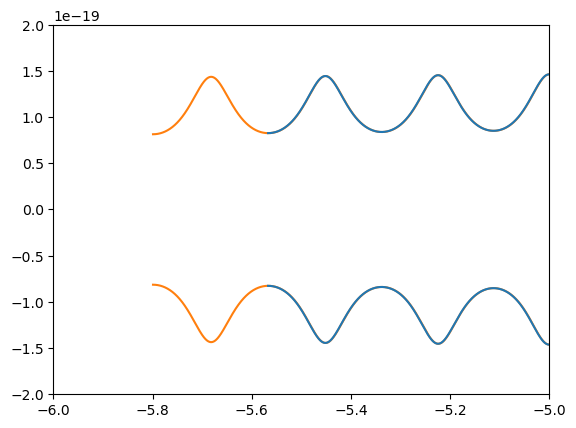

In [26]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_1(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6, -5)
plt.ylim(-2e-19, 2e-19)

Repeating this for high eccentricity however shows inaccuracy:

(-3e-19, 3e-19)

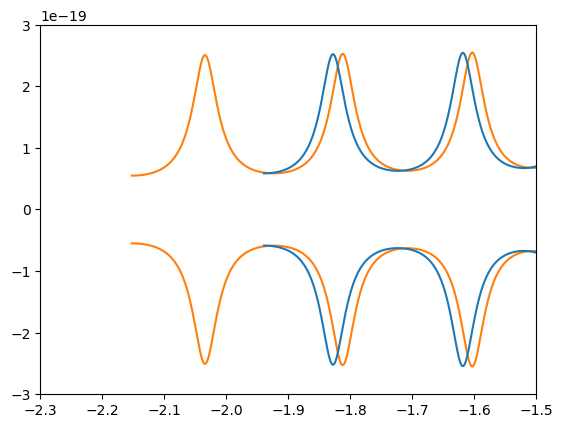

In [4]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_1(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-2.3, -1.5)
plt.ylim(-3e-19, 3e-19)

As well as for high mass ratio and aligned spin:

(-1.5e-19, 1.5e-19)

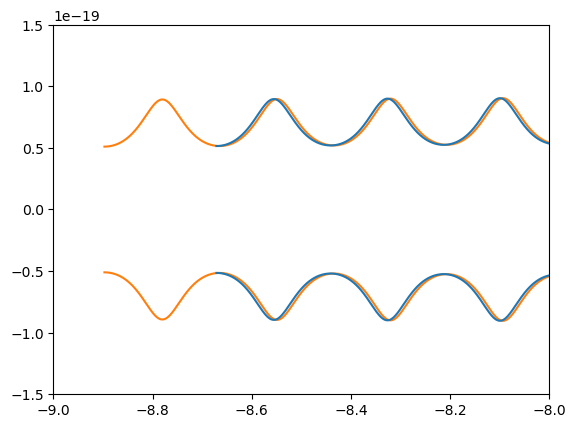

In [5]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 5

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_1(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-9, -8)
plt.ylim(-1.5e-19, 1.5e-19)

(-2e-19, 2e-19)

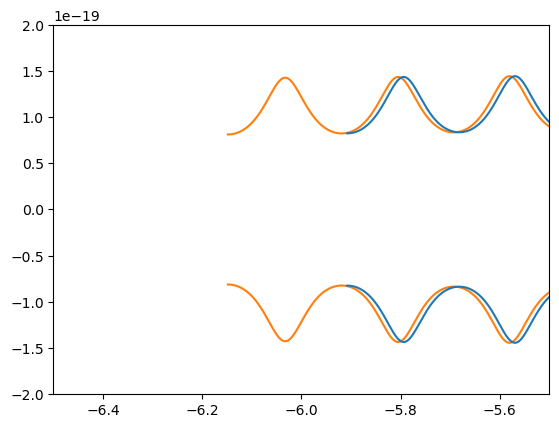

In [6]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_1(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6.5, -5.5)
plt.ylim(-2e-19, 2e-19)

And finally all three:

(-2e-19, 2e-19)

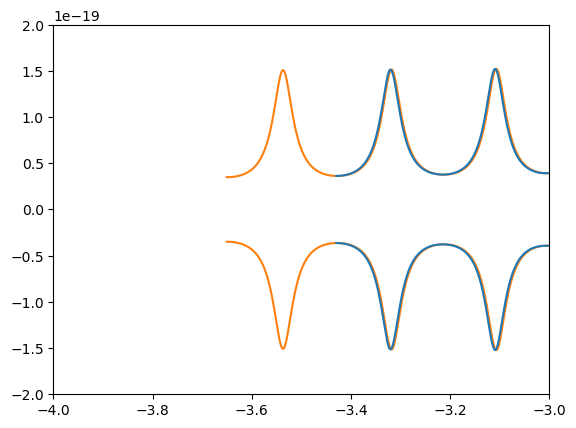

In [7]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 5
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_1(f_low, e, M, q)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-4, -3)
plt.ylim(-2e-19, 2e-19)

# Spin and higher order eccentricity corrections in apsidal advance formula

Barack and Cutler (https://arxiv.org/pdf/gr-qc/0310125) give PN formulae with spin corrections for $\left<\frac{df}{dt}\right>$, $\left<\frac{de}{dt}\right>$, $\left<\frac{d\gamma}{dt}\right>$ in equations 28-30. We could implement these into our equations for shifted_f() (and possible also shifted_e()) more accurate equations in these areas of parameter space. Let's start by just improving $\left<\frac{d\gamma}{dt}\right>$.

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f(2\pi fM)^{2/3} \left(1-e^2\right)^{-1} \left[ 1+\frac{1}{4}\left(2\pi fM\right)^{2/3} \left(1-e^2\right)^{-1}\left(26-15e^2\right) \right] - 12\pi f\cos\lambda\left(S/M^2\right)\left(2\pi fM\right)\left(1-e^2\right)^{-3/2},
$$

with

$$
S =  m_1^2 \chi_1 + m_2^2 \chi_2
$$

for aligned spin systems with $\lambda = 0$.

Replacing $G$ and $c$ constants we get

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f c^{-2} (2\pi fGM)^{2/3} \left(1-e^2\right)^{-1} \left[ 1+\frac{1}{4c^2}\left(2\pi fGM\right)^{2/3} \left(1-e^2\right)^{-1}\left(26-15e^2\right) \right] - 12\pi fc^{-2}\cos\lambda\left(S/M^2\right)\left(2\pi fM\right)\left(1-e^2\right)^{-3/2},
$$

and

$$
S =  \frac{G}{c} \left( m_1^2 \chi_1 + m_2^2 \chi_2 \right).
$$

## Functions

In [8]:
def peri_advance_orbit_2(P, e, M, q, chi1, chi2):

    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 6*np.pi*(2*np.pi*f_orb*const.G*M)**(2/3)/(const.c**2*(1-e**2))
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*(26-15*e**2)/(4*const.c**2*(1-e**2))
    spin_corr = -12*np.pi*(S/M**2)*2*np.pi*f_orb*M/(const.c**2*(1-e**2)**(3/2))
    
    return prefactor*(1+e_corr)+spin_corr

def num_orbits_2(P, e, M, q, chi1, chi2):
    
    delta_phi = peri_advance_orbit_2(P, e, M, q, chi1, chi2)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

def delta_freq_orbit_2(P, e, M, q):
    
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

def shifted_f_2(f, e, M, q, chi1, chi2):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_2(P, e, M, q)
    n_orbit = num_orbits_2(P, e, M, q, chi1, chi2)
    return f - delta_f_orbit*n_orbit

## Results

(-2e-19, 2e-19)

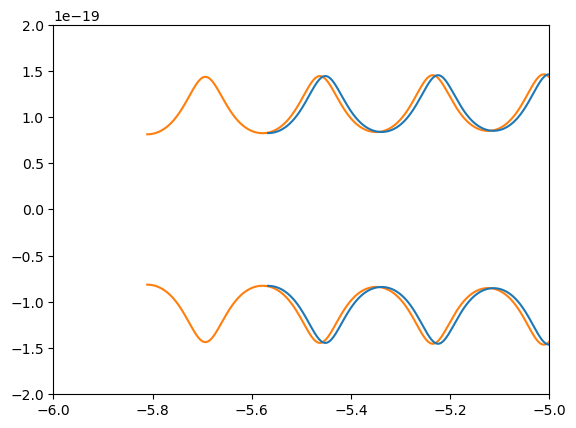

In [27]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_2(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6, -5)
plt.ylim(-2e-19, 2e-19)

(-3e-19, 3e-19)

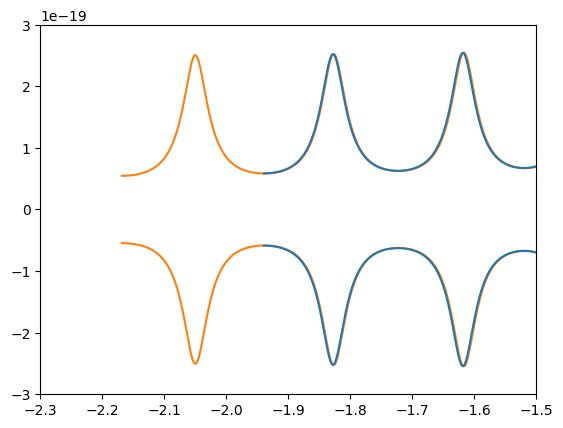

In [10]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 2
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_2(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-2.3, -1.5)
plt.ylim(-3e-19, 3e-19)

(-1.5e-19, 1.5e-19)

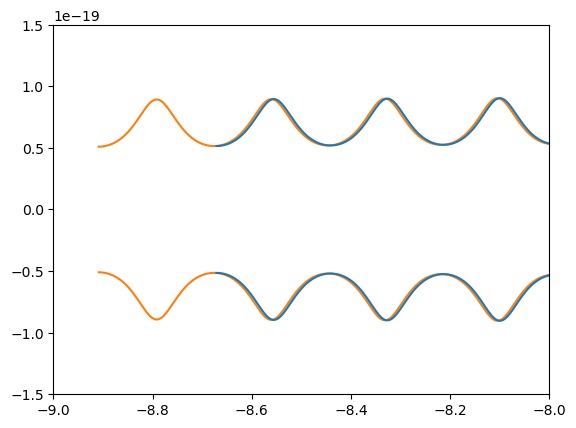

In [11]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 5
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_2(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-9, -8)
plt.ylim(-1.5e-19, 1.5e-19)

(-2e-19, 2e-19)

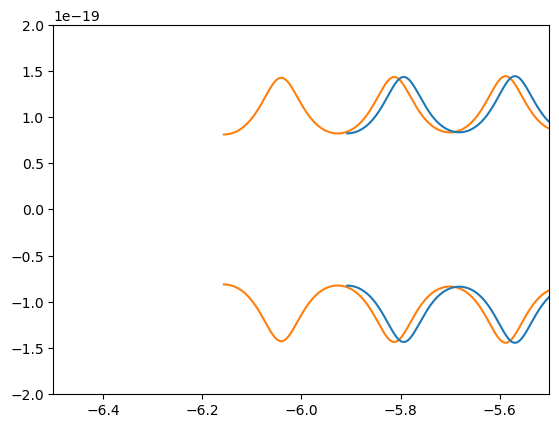

In [12]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_2(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6.5, -5.5)
plt.ylim(-2e-19, 2e-19)

(-2e-19, 2e-19)

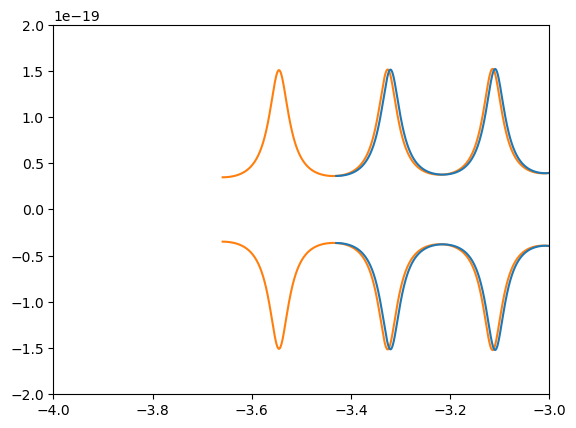

In [13]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 5
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_2(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-4, -3)
plt.ylim(-2e-19, 2e-19)

Overall improvement, with high eccentricity looking especially good. There are still some small residuals however, and the 'control' case actually got worse from including the higher order eccentricity correction term.

# Corrections to frequency evolution in apsidal advance formula

Let's add the same level of corrections to the frequency evolution calculation in the apsidal advance formula and see if this helps rectify the issue for our control case.

Previously, we were using (stressing again that $f$ here is the azimuthal frequency)

$$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi}\left(\mu/M^3\right)\left(2\pi fM\right)^{11/3}\left(1-e^2\right)^{-7/2} \left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right],
$$

and we will now add in corrections to get

$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi} \left(\mu/M^3\right)\left(2\pi fM\right)^{11/3}\left(1-e^2\right)^{-9/2}
$
$$
\times \left\{\left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right]\left(1-e^2\right) + \left(2\pi fM\right)^{2/3} \left[\left(1273/336\right) - \left(2561/224\right)e^2  - \left(3885/128\right)e^4 - \left(13147/5376\right)e^6 \right] - \left(2\pi fM\right)\left(S/M^2\right)\cos\lambda\left(1-e^2\right)^{-1/2}\left[\left(73/12\right) + \left(1211/24\right)e^2  + \left(3143/96\right)e^4 + \left(65/64\right)e^6 \right] \right\}.
$$

Finally adding constants back in we find

$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi} \left(\mu/M^3\right) c^{-5}G^{-2} \left(2\pi fGM\right)^{11/3}\left(1-e^2\right)^{-9/2}
$
$$
\times \left\{\left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right]\left(1-e^2\right) + c^{-2}\left(2\pi fGM\right)^{2/3} \left[\left(1273/336\right) - \left(2561/224\right)e^2  - \left(3885/128\right)e^4 - \left(13147/5376\right)e^6 \right] - c^{-2}\left(2\pi fM\right)\left(S/M^2\right)\cos\lambda\left(1-e^2\right)^{-1/2}\left[\left(73/12\right) + \left(1211/24\right)e^2  + \left(3143/96\right)e^4 + \left(65/64\right)e^6 \right] \right\}.
$$

## Functions

In [14]:
def peri_advance_orbit_3(P, e, M, q, chi1, chi2):

    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 6*np.pi*(2*np.pi*f_orb*const.G*M)**(2/3)/(const.c**2*(1-e**2))
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*(26-15*e**2)/(4*const.c**2*(1-e**2))
    spin_corr = -12*np.pi*(S/M**2)*2*np.pi*f_orb*M/(const.c**2*(1-e**2)**(3/2))
    
    return prefactor*(1+e_corr)+spin_corr

def num_orbits_3(P, e, M, q, chi1, chi2):
    
    delta_phi = peri_advance_orbit_3(P, e, M, q, chi1, chi2)
    n_orbit = (2*np.pi)/(2*np.pi - delta_phi)
    return n_orbit

def delta_freq_orbit_3(P, e, M, q, chi1, chi2):
    
    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    mu = component_masses_to_symmetric_mass_ratio(m1, m2)*M
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 2*P*96*mu*(2*np.pi*f_orb*const.G*M)**(11/3)/(10*np.pi*M**3*const.c**5*const.G**2*(1-e**2)**(9/2))
    e_factor = (1+(73/24)*e**2+(37/96)*e**4)*(1-e**2)
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*((1273/336)-(2561/224)*e**2-(3885/128)*e**4-(13147/5376)*e**6)/const.c**2
    spin_corr = -(2*np.pi*f_orb*M)*(S/M**2)*((73/12)+(1211/24)*e**2+(3143/96)*e**4+(65/64)*e**6)/(const.c**2*(1-e**2)**(1/2))
    
    return prefactor*(e_factor+e_corr+spin_corr)

def shifted_f_3(f, e, M, q, chi1, chi2):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_3(P, e, M, q, chi1, chi2)
    n_orbit = num_orbits_3(P, e, M, q, chi1, chi2)
    return f - delta_f_orbit*n_orbit

(-2e-19, 2e-19)

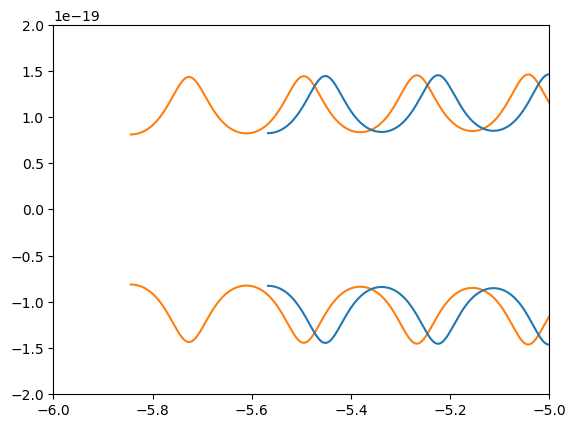

In [15]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_3(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6, -5)
plt.ylim(-2e-19, 2e-19)

(-3e-19, 3e-19)

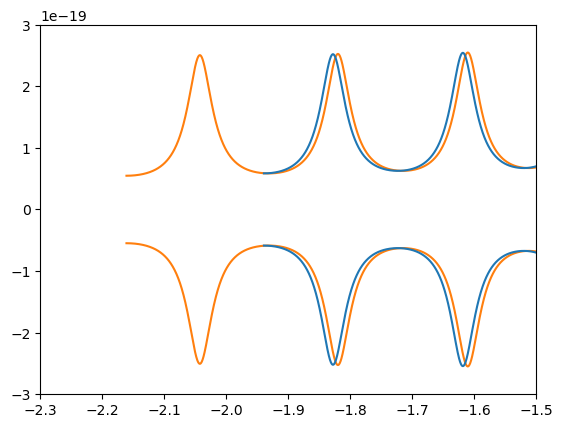

In [16]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 2
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_3(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-2.3, -1.5)
plt.ylim(-3e-19, 3e-19)

(-1.5e-19, 1.5e-19)

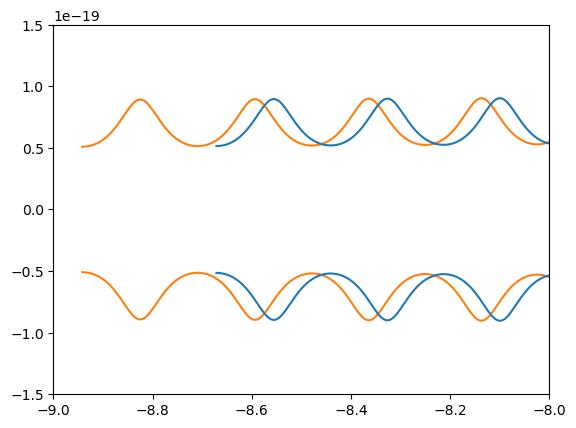

In [17]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 5
chi1 = 0
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS')
s_f = shifted_f_3(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS')

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-9, -8)
plt.ylim(-1.5e-19, 1.5e-19)

(-2e-19, 2e-19)

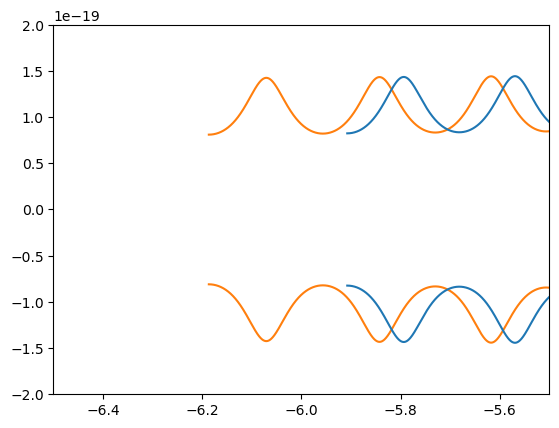

In [18]:
# Parameters
f_low = 10
e = 0.2
M = 60
q = 2
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_3(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-6.5, -5.5)
plt.ylim(-2e-19, 2e-19)

(-2e-19, 2e-19)

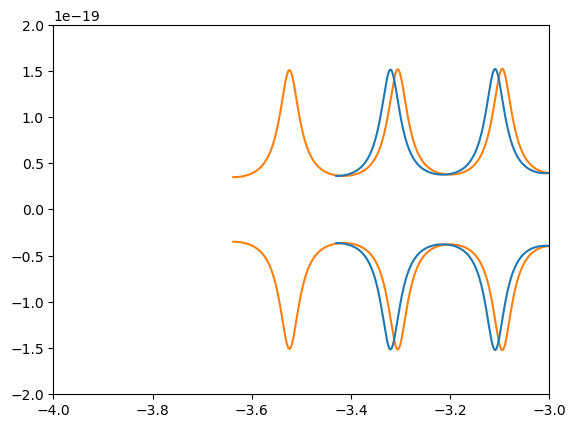

In [19]:
# Parameters
f_low = 10
e = 0.5
M = 60
q = 5
chi1 = 0.5
chi2 = 0

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_f = shifted_f_3(f_low, e, M, q, chi1, chi2)
s_e = shifted_e(s_f, f_low, e)
s_h = gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)

# Plot
plt.plot(s_h.sample_times, np.abs(s_h), c='C1')
plt.plot(s_h.sample_times, -np.abs(s_h), c='C1')
plt.plot(h.sample_times, np.abs(h), c='C0')
plt.plot(h.sample_times, -np.abs(h), c='C0')
plt.xlim(-4, -3)
plt.ylim(-2e-19, 2e-19)

Adding these corrections appears to have made all cases worse - need to check implementation.